In [504]:
import warnings
import importlib
import time
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import convolve2d
from skimage.measure import EllipseModel
from skimage.measure import label as ConnectRegion
from astropy.cosmology import Planck18
from matplotlib.patches import Ellipse
from astropy.coordinates import SkyCoord
from skimage import measure, draw
from scipy.signal import find_peaks

from scipy.ndimage import gaussian_filter

import ztfidr
import galaxy_phot as glp

warnings.filterwarnings('ignore')

In [2]:
importlib.reload(glp)
sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

conds1 = (sample.data['redshift'] > 0 ) & (sample.data['redshift'] < 0.2) 
conds2 = np.intersect1d(host_data.index, sample.data.index)
data = host_data[['host_ra', 'host_dec']].loc[conds2].dropna()[conds1]
targets = data.index
len(data)

3613

In [855]:
class galaxy_decomp:
    def __init__(self, sn_name, verbose, mask, band, source):
        self.verbose = verbose
        self.gobj = glp.HostGal(verbose=verbose)
        self.gobj.init_dr2(sn_name, sample, host_data)
        self.gobj.get_image(source=source, survey='auto', output_='z', band=band, scale=0.262)

        self.contours = {}
        self.image = self.gobj.cutout['mag']
        self.mask, self.center = self.generate_masks() if mask else ([], np.array(self.image.shape)//2)
        

    def plot_fit(self, isophotes, apply_mask=False):
        fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), dpi=100, ncols=2)
        mag, wcs = self.image, self.gobj.cutout['wcs']
        ax2.imshow(mag, cmap='gray', origin='lower')

        (sn_ra, sn_dec) = self.gobj.gal['sn']
        c = SkyCoord(ra=sn_ra*u.degree, dec=sn_dec*u.degree, frame='icrs')
        sn_px = wcs.world_to_pixel(c)
        ax2.scatter(sn_px[0], sn_px[1], c='cyan', s=40, lw=2, fc='None', ec='cyan')
        if np.any(self.mask) & apply_mask:
            for (x, y, a, b, theta) in self.mask:
                m_patch = Ellipse((x, y), 2*a, 2*b, np.rad2deg(theta), edgecolor='black', facecolor='black', zorder=10, alpha=0.5)
                ax1.add_patch(m_patch)

        targets = self.contours.keys() if isophotes == 'all' else isophotes
        for i, iso_i in enumerate(targets):
            params, px_data = self.contours[iso_i]
            xc, yc, a, b, theta, chi2, wi = params
            px_all, px_fit = px_data

            norm = np.stack(np.where((mag.T > iso_i-wi) & (mag.T < iso_i+wi))).T
            ax2.scatter(norm.T[0], norm.T[1], s=1, marker='o', zorder=0, label=f'{iso_i:.0f}')
            if np.any(px_fit):
                ax1.scatter(px_fit.T[0], px_fit.T[1], s=1, marker='o', zorder=1, label=f'{iso_i:.0f} fitted')
            if np.any(px_all):
                ax1.scatter(px_all.T[0], px_all.T[1], s=1, marker='o',zorder=0, label=f'{iso_i:.0f} removed')
           
            if xc != 0:
                ell_patch1 = Ellipse((xc, yc), 2*a, 2*b, np.rad2deg(theta), edgecolor='black', facecolor='none')
                ax1.add_patch(ell_patch1)
                ell_patch2 = Ellipse((xc, yc), 2*a, 2*b, np.rad2deg(theta), edgecolor='lime', facecolor='none')
                ax2.add_patch(ell_patch2)

                ax1.set_xlim(*ax2.get_xlim())
                ax1.set_ylim(*ax2.get_ylim())
        ax1.legend(framealpha=0.8, markerscale=5)
        ax2.legend(framealpha=1, markerscale=5)
        plt.tight_layout()
        return ax1, ax2


    def prep_pixels(self, isophote, blur, window):
        kernal5 = np.array([[ 0,  0,  1,  1,  1],
                            [ 0,  0,  0,  1,  1],
                            [-1,  0,  0,  0,  1],
                            [-1, -1,  0,  0,  0],
                            [-1, -1, -1,  0,  0]])

        kernal_ = 1/(kernal5 + isophote)
        kernal_unit = kernal_ / np.sum(kernal_)
        conv_blur = gaussian_filter(self.image, sigma=blur)
        convolve_1 = convolve2d(conv_blur, kernal_unit, mode='same')
        convolve_2 = convolve2d(convolve_1, kernal_unit[::-1], mode='same')

        convolve_2[:5,:] = 0
        convolve_2[-5:,:] = 0
        convolve_2[:,:5] = 0
        convolve_2[:,-5:] = 0

        contour = np.stack(np.where((convolve_2.T > isophote-window) & (convolve_2.T < isophote+window)))
        return contour.T

    def ellipse_fit(self, px_d):
        ell = EllipseModel()
        ell.estimate(px_d)
        if ell.params is None:
            return (0,0,0,0,0), 0
        else:
            res = ell.residuals(px_d)
            chi2 = np.sum(res**2)/(len(res)-len(ell.params))
            return ell.params, chi2
        
    def generate_masks(self):
        def get_pixels(region, connect): return np.stack(np.where(connect == region))
        def linear_fit(x, a, b): return a*x + b

        contour_data, astro_objects, obj_centers = {}, {}, []

        for iso_i in np.arange(24, 17, -1):
            contour_i = self.prep_pixels(iso_i, blur=1, window=0.6)
            if len(contour_i) == 0:
                continue

            binary_image = np.zeros_like(self.image, dtype=np.uint8)
            binary_image[contour_i.T[0], contour_i.T[1]] = 1
            connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
            region_count = np.asarray(np.unique(connect_, return_counts=True))
            region_count = region_count.T[(region_count[1] > 20) & (region_count[0] != 0)].T

            iso_objects = np.zeros((len(region_count[0]), 6))
            for i, rc in enumerate(region_count[0]):
                px_ = get_pixels(rc, connect_)
                pars, chi2 = self.ellipse_fit(px_.T)
                iso_objects[i] = np.round([*pars, chi2], 2)
            if len(iso_objects.T[0]) > 0:
                contour_data[iso_i] = iso_objects.T
        
        for iso_level in list(contour_data.keys())[::-1]:
            for obj in contour_data[iso_level].T:
                identified = False
                xc_i, yc_i, a_i, b_i, theta_i, chi2_ = obj
                for i, (cx, cy) in enumerate(obj_centers):
                    offset = np.sqrt((xc_i-cx)**2 + (yc_i-cy)**2)
                    if offset < 10:
                        astro_objects[i]['a'].append([iso_level, a_i])
                        astro_objects[i]['b'].append([iso_level, b_i])
                        astro_objects[i]['theta'].append([iso_level, theta_i])
                        identified = True
                        break
                if not identified:
                    obj_centers.append([xc_i, yc_i])
                    astro_objects[len(astro_objects)] = {'a': [[iso_level, a_i]], 'b': [[iso_level, b_i]], 
                                                         'theta': [[iso_level, theta_i]]}
        
        if len(obj_centers) == 0:
            return [], np.array(self.image.shape)//2
        else:
            sizes = np.array([astro_objects[i]['a'][-1][1] for i in astro_objects.keys()])
            galaxy_i = np.argmax(sizes)
            dists = np.sqrt(np.sum(np.square(np.array(obj_centers) - obj_centers[galaxy_i]), axis=1))
            mask_index = np.where((dists-sizes < astro_objects[galaxy_i]['a'][-1][1]*2) & (dists != 0))[0]

            masks = np.zeros((len(mask_index), 5))
            for i, mi in enumerate(mask_index):
                mx, my = obj_centers[mi]
                a_m = np.array(astro_objects[mi]['a'])
                b_m = np.array(astro_objects[mi]['b'])
                theta_m = astro_objects[mi]['theta'][-1][1]
                if len(a_m)>2:
                    out_ma = curve_fit(linear_fit, a_m.T[0], a_m.T[1])
                    out_mb = curve_fit(linear_fit, b_m.T[0], b_m.T[1])
                    ai, bi = linear_fit(25, *out_ma[0])*1.5, linear_fit(25, *out_mb[0])*1.5
                else:
                    ai, bi = a_m[-1][1]*(3+(24-a_m[-1][0])/2), b_m[-1][1]*(3+(24-a_m[-1][0])/2)
                masks[i] = [mx, my, ai, bi, theta_m]
            offset = np.linalg.norm(np.array(self.image.shape)//2 - obj_centers[galaxy_i])
            print(f'masks: {len(masks)}, offset: {offset:.0f}px') if self.verbose else None
            return masks, obj_centers[galaxy_i]


    def extract_region(self, isophote_data, apply_mask=False):
        def get_pixels(region, connect): return np.stack(np.where(connect == region))

        binary_image = np.zeros_like(self.image, dtype=np.uint8)
        binary_image[isophote_data.T[0], isophote_data.T[1]] = 1
        connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
        region_count = np.asarray(np.unique(connect_, return_counts=True))
        region_count = region_count.T[(region_count[1] > 10) & (region_count[0] != 0)].T

        region_offset = np.zeros_like(region_count[0])
        for i, reg_i in enumerate(region_count[0]):
            px_i = get_pixels(reg_i, connect_)
            px_center = np.mean(px_i, axis=1)
            region_offset[i] = np.linalg.norm(px_center-self.center)
        galaxy_region = region_count[0][np.argmin(region_offset)]
        
        if np.any(self.mask) & apply_mask:
            for (x, y, a, b, ang) in self.mask:
                ell_px = draw.ellipse(x, y, a, b, rotation=ang)
                mask = np.ones_like(self.image)
                px_cutoff = (ell_px[0] < self.image.shape[0]) & (ell_px[1] < self.image.shape[0])
                mask[ell_px[0][px_cutoff], ell_px[1][px_cutoff]] = 0
                connect_ = connect_ * mask

        return get_pixels(galaxy_region, connect_).T
        
    def contour_fit(self, isophote, window, mask=False):
        all_pixels = self.prep_pixels(isophote, blur=1, window=window)
        if np.any(all_pixels):
            fit_pixels = self.extract_region(all_pixels, apply_mask=mask)
            pars, chi2 = self.ellipse_fit(fit_pixels)
            self.contours[isophote] = [[*pars, chi2, window], [all_pixels, fit_pixels]]

    def main_run(self):
        pass

In [856]:
sn_i = 20
sn_name = targets[sn_i]# 'ZTF20acwmpsj'
gd = galaxy_decomp(sn_name, verbose=True, mask=True, band='g', source='save')

ZTF18aabyhlc 226.84713 38.41676 0.0289586 z_snid
legacy 480 0.262
masks: 2, offset: 49px


In [857]:
iso = 25
gd.contour_fit(iso, 0.3, mask=True)

(<AxesSubplot:>, <AxesSubplot:>)

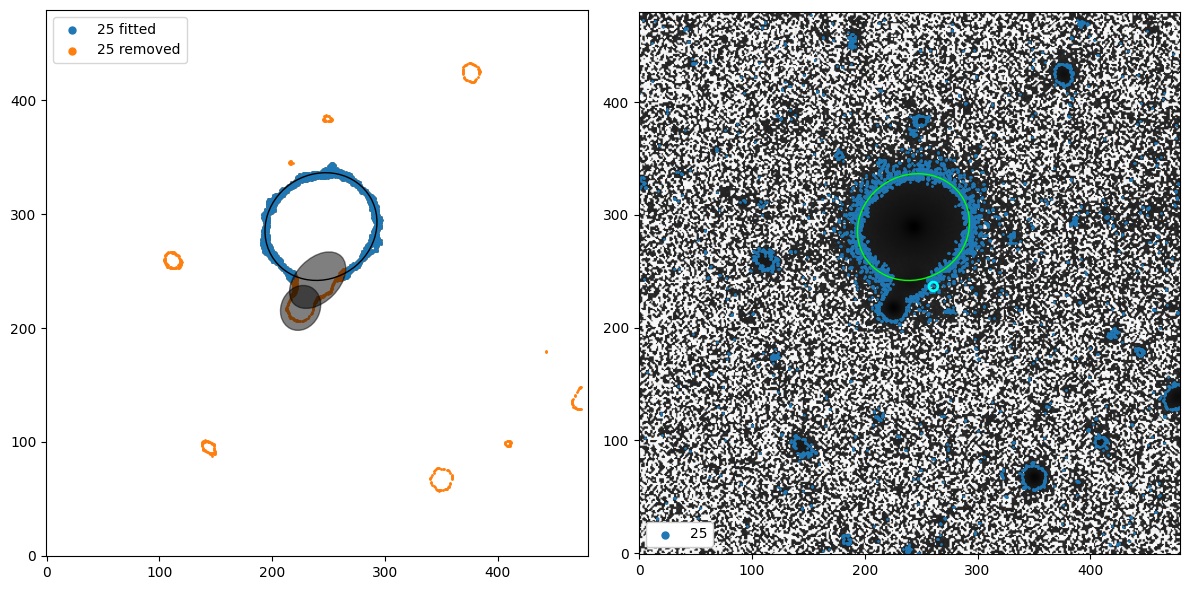

In [858]:
gd.plot_fit([iso], apply_mask=True)

In [380]:
sn_name = 'ZTF20acwmpsj'# 'ZTF18aahfzea'
gobj = glp.HostGal(verbose=True)
gobj.init_dr2(sn_name, sample, host_data)
gobj.get_image(source='save', survey='auto', output_='z', band='g', scale=0.262)

ZTF20acwmpsj 122.91033 -2.3300799999999997 0.051820000000000005 z_gal
legacy 264 0.262


In [381]:
def prep(iso, width):
    kernal5 = np.array([[ 0,  0,  1,  1,  1],
                                [ 0,  0,  0,  1,  1],
                                [-1,  0,  0,  0,  1],
                                [-1, -1,  0,  0,  0],
                                [-1, -1, -1,  0,  0]])

    mag = gobj.cutout['mag']
    kernal_ = 1/(kernal5 + 23)
    kernal_unit = kernal_ / np.sum(kernal_)
    conv_blur = gaussian_filter(mag, sigma=1)
    convolve_1 = convolve2d(conv_blur, kernal_unit, mode='same')
    convolve_2 = convolve2d(convolve_1, kernal_unit[::-1], mode='same')

    convolve_2[:5,:] = 0
    convolve_2[-5:,:] = 0
    convolve_2[:,:5] = 0
    convolve_2[:,-5:] = 0

    # out_region = convolve_2 > (iso - width)
    # in_region = convolve_2 < (iso - width)
    # min_region = min(len(out_region))
    # Y, X = np.ogrid[:len(mag), :len(mag)]
    # dist_from_center = np.sqrt((X - len(mag)//2)**2 + (Y - len(mag)//2)**2)
    # mask = dist_from_center <= 100
    # convolve_2 = convolve_2 * mask

    # contour_l = np.stack(np.where((convolve_2.T > iso-width) & (convolve_2.T < iso))).T
    # contour_u = np.stack(np.where((convolve_2.T > iso) & (convolve_2.T < iso+width))).T
    contour = np.stack(np.where((convolve_2.T > iso-width) & (convolve_2.T < iso+width))).T
    return contour

In [480]:
gal, obj_centers[gal]

(3, [131.44, 131.52])

In [478]:
binary_image = np.zeros_like(mag, dtype=np.uint8)
binary_image[contour.T[0], contour.T[1]] = 1
connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
region_count = np.asarray(np.unique(connect_, return_counts=True))
region_count = region_count.T[(region_count[1] > 10) & (region_count[0] != 0)].T
region_count

array([[   1,    2,    3,    4,    5,    6,    7,    8],
       [  19,   40, 5905,   46,   46,   40,  380,   82]], dtype=int64)

In [495]:
def get_pixels(region, connect): return np.stack(np.where(connect == region))

region_offset = np.zeros_like(region_count[0])
for i, reg_i in enumerate(region_count[0]):
    px_i = get_pixels(reg_i, connect_)
    px_center = np.mean(px_i, axis=1)
    region_offset[i] = np.linalg.norm(obj_centers[gal]-px_center)

region_count[0][np.argmin(region_offset)]

In [499]:
region_count[0][np.argmin(region_offset)]

3

In [ ]:

binary_image = np.zeros_like(mag, dtype=np.uint8)
binary_image[isophote_data.T[0], isophote_data.T[1]] = 1
connect_ = ConnectRegion(binary_image, connectivity=2, background=0)

region_count = np.asarray(np.unique(connect_, return_counts=True))
n_biggest = -np.arange(2, min(len(region_count[1])+1, 6))
largest_regions = np.partition(region_count[1], n_biggest)[n_biggest]
largest_regions = largest_regions[largest_regions > 24]
# print(largest_regions) if self.verbose else None

def get_pixels(count_):
    return np.stack(np.where(connect_ == np.where(region_count[1] == count_)[0]))

def region_loc(count_):
    region_i = get_pixels(count_)
    return np.sum((region_i.mean(axis=1) - len(connect_)//2)**2)

if len(largest_regions) != 0:
    arg_ = np.argpartition(np.vectorize(region_loc)(largest_regions), near)[near]
    return get_pixels(largest_regions[arg_]).T
else:
    return []

In [472]:
def get_pixels(region, connect):
    return np.stack(np.where(connect == region))

def fit(px_d):
    ell = EllipseModel()
    ell.estimate(px_d)
    res = ell.residuals(px_d)
    chi2 = np.sum(res**2)/(len(res)-len(ell.params))
    return ell.params, chi2

In [473]:
def run1(iso):
    contour_i = prep(iso, width=1)
    mag = gobj.cutout['mag']

    binary_image = np.zeros_like(mag, dtype=np.uint8)
    binary_image[contour_i.T[0], contour_i.T[1]] = 1
    connect_ = ConnectRegion(binary_image, connectivity=2, background=0)
    region_count = np.asarray(np.unique(connect_, return_counts=True))
    region_count = region_count.T[(region_count[1] > 10) & (region_count[0] != 0)].T

    iso_objects = np.zeros((len(region_count[0]), 6))
    for i, rc in enumerate(region_count[0]):
        px_ = get_pixels(rc, connect_)
        pars, chi2 = fit(px_.T)
        iso_objects[i] = np.round([*pars, chi2], 2)
    return iso_objects.T

In [474]:
astro_objects = {}
for iso_i in np.arange(24, 15, -1):
    iso_objects = run1(iso_i)
    if len(iso_objects[0]) > 0:
        astro_objects[iso_i] = iso_objects

In [475]:
obj_centers = []
objects = {}

mag = gobj.cutout['mag']
img_cent = len(mag)//2
for iso_level in list(astro_objects.keys())[::-1]:
    for obj in astro_objects[iso_level].T:
        identified = False
        xc_i, yc_i, a_i, b_i, theta_i, chi2_ = obj
        for i, (cx, cy) in enumerate(obj_centers):
            offset = np.sqrt((xc_i-cx)**2 + (yc_i-cy)**2)
            if offset < 10:
                objects[i]['a'].append([iso_level, a_i])
                objects[i]['b'].append([iso_level, b_i])
                objects[i]['theta'].append([iso_level, theta_i])
                identified = True
                break
        if not identified:
            obj_centers.append([xc_i, yc_i])
            objects[len(objects)] = {'a': [[iso_level, a_i]], 'b': [[iso_level, b_i]], 'theta': [[iso_level, theta_i]]}

In [476]:
gal = np.argmax([objects[i]['a'][-1][1] for i in objects.keys()])
dists = np.sqrt(np.sum(np.square(np.array(obj_centers) - obj_centers[gal]), axis=1))
sizes = np.array([objects[oi]['a'][-1][1] for oi in objects.keys()])
masks = np.where((dists-sizes < objects[gal]['a'][-1][1]*2) & (dists != 0))[0]
masks

array([0, 1, 2, 8, 9], dtype=int64)

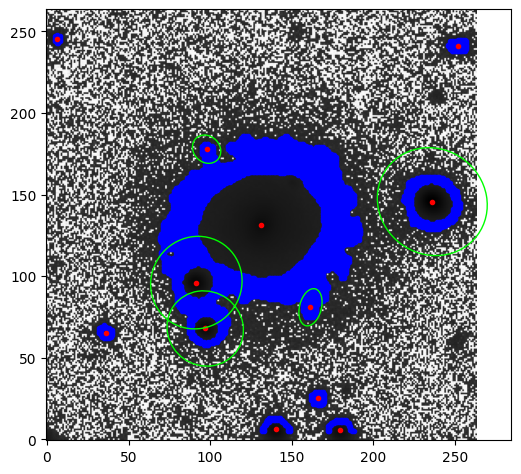

In [477]:
def func(x, a, b): return a*x + b

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.imshow(mag, origin='lower', cmap='gray')
width=1
contour = prep(24, width)
ax.plot(contour.T[0], contour.T[1], 'b.')
for cx, cy in obj_centers:
    ax.plot(cx, cy, 'r.')

for mi in masks:
    mx, my = obj_centers[mi]
    multi = 2
    a_m = np.array(objects[mi]['a'])
    b_m = np.array(objects[mi]['b'])
    if len(a_m)>2:
        out_ma = curve_fit(func, a_m.T[0], a_m.T[1])
        out_mb = curve_fit(func, b_m.T[0], b_m.T[1])
        ai, bi = func(25, *out_ma[0])*(1+width), func(25, *out_mb[0])*(1+width)
    else:
        ai, bi = a_m[-1][1]*5, b_m[-1][1]*5

    theta_m = objects[mi]['theta'][-1][1]
    ell_patchm = Ellipse((mx, my), 2*ai, 2*bi, np.rad2deg(theta_m), edgecolor='lime', facecolor='none', zorder=10, lw=1)
    ax.add_patch(ell_patchm)

In [503]:
time

Wall time: 0 ns


In [315]:
func(25, *out[0])

14.376000006471905

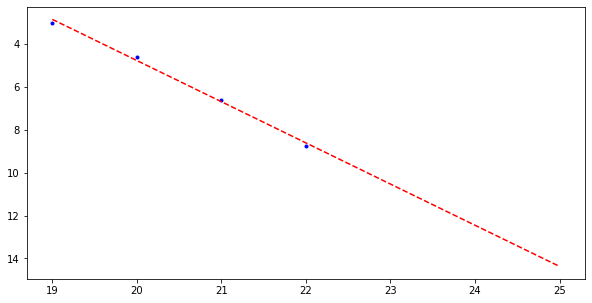

In [313]:
fig, ax = plt.subplots(figsize=(10, 5))
cr = np.array(objects[1]['a'])
ax.plot(cr.T[0], cr.T[1], 'b.')
ax.plot(x_ax, func(x_ax, *out[0]), 'r--')
ax.invert_yaxis()